<h1><center>Tutorial on A/B Testing</center></h1>

In [1]:
# loading all the requisite libraries that will be required for the toy model
import scipy.stats as st
from scipy.stats import beta,norm,binom
import matplotlib.pyplot as mplt
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import math


We use data from Kaggle <a href="https://www.kaggle.com/yufengsui/mobile-games-ab-testing">here</a>. Its a data on mobile game retention (a user does not uninstall the app). 1 day retention = user comes back to use the app one day after installing the app. 7 day retention = user comes back to use the app 7 days after uninstalling. We can start with analyzing the data.

In [2]:
data = pd.read_csv("data.csv")

In [3]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


control        = gate_30 in column: version <br>
treatment      = gate_40 in column: version <br>
sum_gamerounds = number of games a user played in first 14 days after installing the app

<h3>Data Exploration</h3>

In [4]:
print(data['version'].value_counts())
print("NOTE:Number of users in control and treatment group are similar")

gate_40    45489
gate_30    44700
Name: version, dtype: int64
NOTE:Number of users in control and treatment group are similar


In [5]:
print(data['retention_1'].value_counts())

False    50036
True     40153
Name: retention_1, dtype: int64


In [6]:
print(data['retention_7'].value_counts())

False    73408
True     16781
Name: retention_7, dtype: int64


Box plot shows that there is one outlier, we can filter now but outliers should be investigated as why such a big number is observed


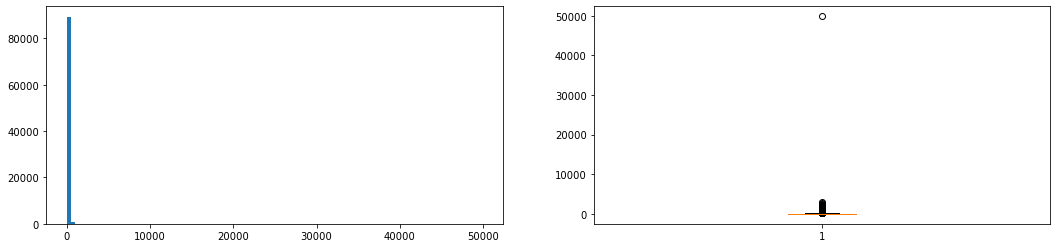

In [7]:
fig = mplt.figure(figsize=(18,4))
mplt.subplot(1,2,1)
mplt.hist(data['sum_gamerounds'],bins=100);

mplt.subplot(1,2,2)
mplt.boxplot(data['sum_gamerounds']);

print("Box plot shows that there is one outlier, we can filter now but outliers should be investigated as why such a big number is observed")

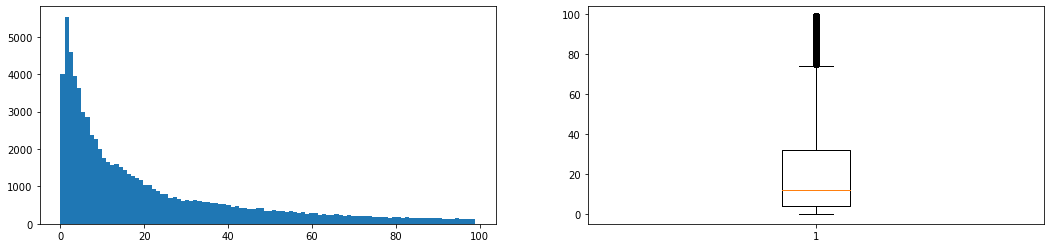

In [8]:
# filtering the data
# assuming that user have played at max 100 games (to ensure we are colleting data from legitimate data and not bots)
data = data[data['sum_gamerounds']<100]

fig = mplt.figure(figsize=(18,4))
mplt.subplot(1,2,1)
mplt.hist(data['sum_gamerounds'],bins=100);

mplt.subplot(1,2,2)
mplt.boxplot(data['sum_gamerounds']);

# note that there are gaps in the histogram of the columns sum_gamerouds: this could be an error and should be checked.

In [9]:
print('there are {a} users wiht null gamerounds from a total of {b} users (after removing the outlier)'.format(a = data['sum_gamerounds'].isna().sum(), b = data['sum_gamerounds'].count()))

there are 0 users wiht null gamerounds from a total of 77673 users (after removing the outlier)


In [10]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
3,483,gate_40,1,False,False
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False


<h3>A/A Testing</h3>

We first use data for the 10,000 users from control group for our A/A testing and building the prior (getting an idea of the probability of uninstalls)

In [11]:
# first collecting the data for A/A testing from the control group 
# for that, randomize the data and collect first 10,000 users data for the control group
# then split these 10,000 users into two groups of 5000 randomly

# random seed is to get the same results everytime the code is run
np.random.seed(0)


# shuffle randomly
data_random  = data[data['version']=='gate_30'].sample(frac=1).reset_index(drop=True)

# shuffle again (not really required here as we have already shuffled but for the sake of randomization)
random_index = np.random.permutation(10000)
data_A1     = data_random.iloc[random_index[0:5000]]
data_A2     = data_random.iloc[random_index[5000:10000]]

# we make sure that these users are not selected for our A/B testing as we have already seen their data
# to make the sample size for A/B approximately similar, we can remove first 10,000 users from treatement group
data_control = data_random.iloc[10000:]
data_treatment = data[data['version']=='gate_40'].sample(frac=1).reset_index(drop=True).iloc[10000:]

data_A1.shape,data_A2.shape,data_control.shape, data_treatment.shape

((5000, 5), (5000, 5), (28532, 5), (29141, 5))

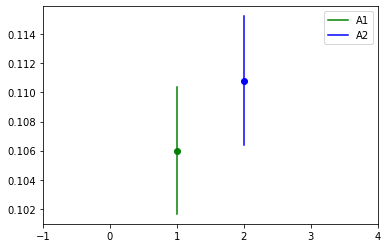

In [12]:
# check the probability of uninstalls (we consider day 7 retention as our metric in this case) fro A/A testing
p_A1 = data_A1['retention_7'].value_counts().values[1]/len(data_A1) #we use values[1] bc we want the True value (False would be 0)
p_A2 = data_A2['retention_7'].value_counts().values[1]/len(data_A2)

# We can use normal approximation for calculating the confidence interval  
ll_A1,ul_A1 = p_A1-np.sqrt((p_A1*(1-p_A1))/len(data_A1)),p_A1+np.sqrt((p_A1*(1-p_A1))/len(data_A1))
ll_A2,ul_A2 = p_A2-np.sqrt((p_A2*(1-p_A2))/len(data_A2)),p_A2+np.sqrt((p_A2*(1-p_A2))/len(data_A2))

mplt.plot([1,1],[ll_A1,ul_A1],color='green',label='A1')
mplt.plot([2,2],[ll_A2,ul_A2],color='blue', label='A2')
mplt.scatter([1],[p_A1],color='green')
mplt.scatter([2],[p_A2],color='blue')
mplt.legend();
mplt.xlim(-1,4);

<u>Observation</u> <br>
We can observe that the confidence intervals intersect. So statistically, there is no difference between the two groups in A/A testing. This is a good sanity check to perform and check if the data is collected correctly. We can also draw the distribution of 'sum_gameround' to check if the distribution across the two groups in similar. 


The following figure also illustrates that we should keep a track of other metrics as well and they should still make sense.

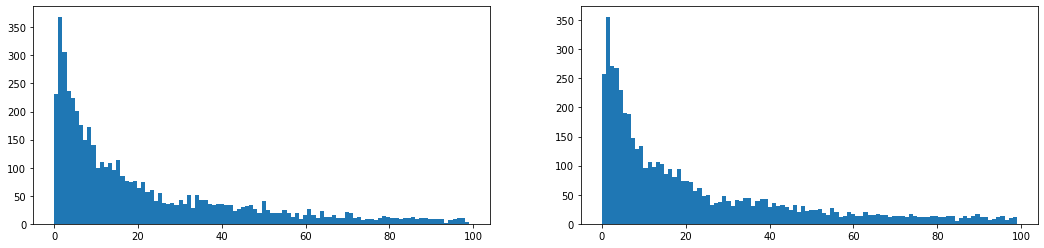

In [13]:
fig = mplt.figure(figsize=(18,4))
mplt.subplot(1,2,1)
mplt.hist(data_A1['sum_gamerounds'],bins=100);

mplt.subplot(1,2,2)
mplt.hist(data_A2['sum_gamerounds'],bins=100);

In [14]:
# collecting data for the prior distribution
# this is the retention rate in the app (we can collect more than 10,000 user to build prior, these are subjective questions)
# and they can be answered best by people with domain knowledge in the company
np.random.seed(0)

data_prior  = data[data['version']=='gate_30'].sample(frac=1).reset_index(drop=True).iloc[0:10000]
p_prior     = data_prior['retention_7'].value_counts().values[1]/len(data_prior)

p_prior

0.1084

<h3>A/B testing</h3>

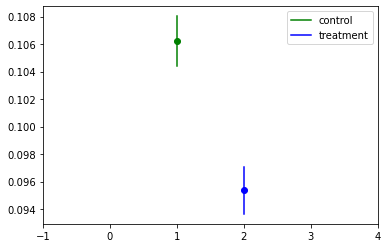

In [15]:
# check the probability of uninstalls (we consider day 7 retention as our metric in this case) fro A/A testing
p_control = data_control['retention_7'].value_counts().values[1]/len(data_control)
p_treatment = data_treatment['retention_7'].value_counts().values[1]/len(data_treatment)

# We can use normal approximation for calculating the confidence interval  
ll_control,ul_control = p_control-np.sqrt((p_control*(1-p_control))/len(data_control)),p_control+np.sqrt((p_control*(1-p_control))/len(data_control))
ll_treatment,ul_treatment = p_treatment-np.sqrt((p_treatment*(1-p_treatment))/len(data_treatment)),p_treatment+np.sqrt((p_treatment*(1-p_treatment))/len(data_treatment))

mplt.plot([1,1],[ll_control,ul_control],color='green',label='control')
mplt.plot([2,2],[ll_treatment,ul_treatment],color='blue', label='treatment')
mplt.scatter([1],[p_control],color='green')
mplt.scatter([2],[p_treatment],color='blue')
mplt.legend();
mplt.xlim(-1,4);

<u>Observation</u> <br>
We can observe that the 7 day retention for the control group (gate_30) is higher than the treatment group (and statistically different too). Thus, we can say that it is better to keep gate_30 rather than gate_40 if the company wants higher retention. NOTE that the results have been obtained based on some filtering we did earlier. Results might change based on how we use the filter and all these analysis should be done before presenting the final conclusion.

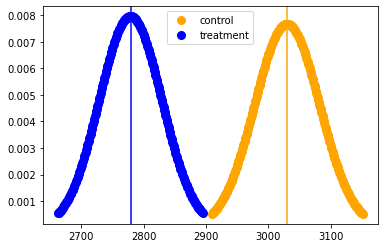

In [16]:
n  = len(data_control)
p  = data_control['retention_7'].value_counts().values[1]/n
x = np.arange(binom.ppf(0.01, n, p),binom.ppf(0.99, n, p))
mplt.plot(x, binom.pmf(x, n, p), 'o', ms=8, label='control',color='orange')
mplt.axvline(x=n*p,c='orange')                            

n  = len(data_treatment)
p  = data_treatment['retention_7'].value_counts().values[1]/n
x = np.arange(binom.ppf(0.01, n, p),binom.ppf(0.99, n, p))
mplt.plot(x, binom.pmf(x, n, p), 'o', ms=8, label='treatment',color='blue')
mplt.axvline(x=n*p,c='blue') 
mplt.legend();


In [17]:
def trueFalse(x):
    if 'True' in str(x):
        c = 1
    else:
        c = 0
    return(c)
print('performing t test')
distribution1 = data_control['retention_7'].apply(lambda x:trueFalse(x))
distribution2 = data_treatment['retention_7'].apply(lambda x:trueFalse(x))
print(st.ttest_ind(distribution1,distribution2))

performing t test
Ttest_indResult(statistic=4.3223274439107175, pvalue=1.5465013030125154e-05)


<u>Observation</u> <br>
p value < 0.05 shows that the the performance of gate_30 and gate_40 (control and treatment) is significantly (statistically) different. Since retention is lower for gate_40, gate_30 (control) should be continued and gate_40 (treatment) should not be introduced. This also shows that A/B testing may not always be improving the system, they might make the system worse.

<h3>sample size</h3>

After we finish the first run, we observe that the treatment group performs worse than the control group and thus gate_40 should not be introduced in the app. However, was the sample size big enough? Our analysis considered around 27000 samples for each group. We can check sample size based on what difference we would like to observe. We will use p_prior as our baseline probability.

Result below show that we do NOT have enough samples in our data to observe a 1% difference between the metric in control and treatment group. We can detect not lower than 5% change. However, if we want to detect a 1% change in the performance, we should collect more data. Thus before rejecting the treatment, more samples are to be calculated.

In [18]:
@interact(delta=(0.01,0.1,0.001), power=(0.6,0.95,0.05))
def posterior(delta=0.01,power=0.6):
    p = p_prior
    z_alpha = st.norm.ppf(1-0.05/2)    # significance level = 0.05
    z_beta  = st.norm.ppf(power/2)
    print('p:',p,'\ndelta value:',delta, 'power value:',power)
    var_p = p*(1-p)
    size = 2*int(var_p*math.pow(z_alpha+z_beta,2)/math.pow(delta*p,2))
    print("\nsample size:", size)

interactive(children=(FloatSlider(value=0.01, description='delta', max=0.1, min=0.01, step=0.001), FloatSlider…

<h2>More on When to Stop A/B Testing</h2>

It is important to understand when should we stop the experiment (or for how long the A/B testing be continued to collect enough data). <b>We checked the p-value at the end of the data collection</b>. It is a common mistake to stop the experiment too soon and make wrong decision. However, conducting the experiments can be expensive. The method of using p-value for identifying if the treatment performs good or not assumes we know the sample size and effect we want to check ($\delta$). Sometimes, we dont know how much $\delta$ we can gain from the feature we are testing. For example, if $\delta$ of 0.2% can be observed, but we are only interested in 2%, our experiments will never be significant (which may cause loss of 0.2% potential gain). However, as more data is collected, and continuously check the p-value, we may observe fluctuating p-value and we are likely to see an effect, even if there is none. So when should we stop?

<img src="airBnB.png" width="800">
<center>Image from AirBnB (<a href="https://medium.com/airbnb-engineering/experiments-at-airbnb-e2db3abf39e7">here</a>)</center>

In [19]:
# We can also check out test for continuous monitoring
# We can plot p-value after every 1000 data points.

def trueFalse(x):
    if 'True' in str(x):
        c = 1
    else:
        c = 0
    return(c)

distribution1 = data_control['retention_7'].apply(lambda x:trueFalse(x))
distribution2 = data_treatment['retention_7'].apply(lambda x:trueFalse(x))

p_value = []
p_A1    = []
p_A2    = []

# we obtain values 28 times (every 1000)
for t in range(28):
    p_value.append(st.ttest_ind(distribution1.iloc[0:1000*(t)],distribution2.iloc[0:1000*(t)])[1])
    p_A1.append(np.mean(distribution1.iloc[0:1000*(t)]))
    p_A2.append(np.mean(distribution2.iloc[0:1000*(t)]))

Text(0.5, 0, 'number of data points x 1000')

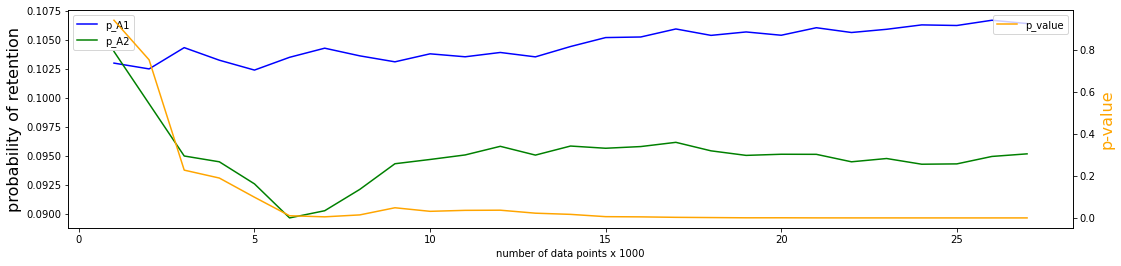

In [20]:
fig,ax = mplt.subplots(1,1,figsize=(18,4))
ax.plot(p_A1,label='p_A1',color='blue')
ax.plot(p_A2,label='p_A2',color='green')
ax.legend()
ax.set_ylabel('probability of retention',fontsize=16)
ax2 = ax.twinx()
ax2.plot(p_value,label='p_value',color='orange')
ax2.legend()
ax2.set_ylabel('p-value',color='orange',fontsize=16);
ax.set_xlabel('number of data points x 1000')

<u>Observation</u> <br>
When the number of observations is lower, p value is highly volatile. As more and more data is collected, p-value, p_A1 and pA2 become stable (so we are safe to make a decision that gate_40 may not be a better alternative to gate_30 however, more data may have to be collected).